## License

MIT License  
Copyright (c) 2024 Saurabh Shivpuje  

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.

# Amplitude Damping Channel Using UAVQD

This notebook demonstrates a vectorized approach to simulating amplitude damping on qubit-qumode systems.

What you'll learn:

- How to set up the system and environment for amplitude damping.
- How to run vectorized simulations for multiple parameter sets efficiently.
- How to visualize populations and observables over time.

Notebook structure:

1. Imports and helper functions — load required modules and utility functions.
2. Problem setup — define system, initial states, and damping parameters.
3. Vectorized simulation — run simulations across parameter grids.
4. Analysis & plotting — visualize the results and compare with reference methods.

Tips:

- Run cells in order. If a long simulation cell is present, consider running it on a smaller parameter subset first.
- If you see import errors, double-check that the virtual environment is activated and dependencies from `pyproject.toml` are installed.

Let's begin with the imports.

## Imports

This section imports required packages and helper functions used throughout the notebook.

In [2]:
import numpy as np
from scipy.linalg import expm
from numpy import kron
from itertools import combinations, product
import matplotlib.pyplot as plt

For detailed explaination, refer to:
1. Chen, Huo, Niladri Gomes, Siyuan Niu, and Wibe Albert de Jong. "Adaptive variational simulation for open quantum systems." arXiv preprint arXiv:2305.06915 (2023).
2. Shivpuje, Saurabh, Manas Sajjan, Yuchen Wang, Zixuan Hu, and Sabre Kais. "Designing variational ansatz for quantum-enabled simulation of non-unitary dynamical evolution-an excursion into Dicke supperradiance." arXiv preprint arXiv:2403.04653 (2024).

 Unlike closed quantum systems, which can be described by pure states represented by wave functions, open quantum systems are often described using density matrices to account for the mixed states resulting from interactions with the environment. 

Lindblad equation:
\begin{equation}\tag{1}
\frac{d \rho(t)}{dt} = -i[H(t), \rho(t)] + \mathcal{L}[\rho(t)]
\end{equation}

where,

\begin{equation}\tag{2}
\mathcal{L}[\rho(t)] = \sum_{k=1}^K \gamma_k \left( L_k \rho(t) L_k^\dagger - \frac{1}{2} \{L_k^\dagger L_k, \rho(t)\} \right)
\end{equation}

\begin{equation}\tag{3}
\rho \mapsto \text{vec}(\rho) = |\nu\rangle \:\:\:\:\: \rm{where} \:\:\:\:
|\nu\rangle \equiv [\rho_{11},\rho_{12},\cdots,\rho_{21},\rho_{22},\cdots,\rho_{NN}]^{\mathrm{T}} \in C^{N^2}
\end{equation}


\begin{equation}\tag{4}
\frac{d}{dt}|\nu(t)\rangle = - \mathrm{i} H_{\mathrm{eff}}(t)|\nu(t)\rangle,
\end{equation}

where,

\begin{equation}\tag{4.a}
H_{\mathrm{eff}} = I \otimes H - H^{T} \otimes I + \mathrm{i} \sum_k \left[L_k^{\ast} \otimes L_k - \frac{1}{2}(I \otimes L_k^{\dagger}L_k + L_k^{T}L_k^{\ast} \otimes I ) \right],
\end{equation}

using the identity
\begin{equation}\tag{4.b}
\text{vec}(ABC) = (C^T \otimes A) \text{vec}(B)
\end{equation}

\begin{equation}\tag{5}
H_{\text{eff}} \equiv H_e - i H_a
\end{equation}

where,

\begin{equation}\tag{5.a}
H_e = \frac{H_{\mathrm{eff}} + H_{\mathrm{eff}}^{\dagger}}{2}
\end{equation}
and
\begin{equation}\tag{5.b}
H_a = \mathrm{i} \frac{H_{\mathrm{eff}} - H_{\mathrm{eff}}^{\dagger}}{2}
\end{equation}

### Vectorized Effective Hamiltonian


In [3]:
def vectorize_comm(A):
    # Create an identity matrix with the same dimension as A
    iden = np.eye(A.shape[0])
    # Compute the vectorized commutator [A, .] as the Kronecker product 
    return kron(iden, A) - kron(A.T, iden)

class VectorizedEffectiveHamiltonian_class:
    def __init__(self, He, Ha):
        self.He = He
        self.Ha = Ha

def VectorizedEffectiveHamiltonian(H, gamma, lind):
    # Create an identity matrix with the same dimension as H
    iden = np.eye(H.shape[0])
    # Get the dimension of H
    d = H.shape[0]
    # Compute the vectorized commutator for the Hamiltonian H
    vec_H = vectorize_comm(H)
    # Initialize the result matrix with zeros (complex type)
    res = np.zeros((d**2, d**2), dtype=np.complex128)
    
    # Compute the conjugate of the Lindblad operator
    L_conj = lind.conj()
    L_dagger_L = L_conj.T @ lind
    # Compute the Lindblad contribution to the effective Hamiltonian
    res -= gamma * (kron(L_conj, lind) - (kron(iden, L_dagger_L) + kron(L_dagger_L.T, iden)) / 2)

    # Return an instance of the VectorizedEffectiveHamiltonian_class with vec_H and res
    return VectorizedEffectiveHamiltonian_class(vec_H, res)


## Problem setup

Define the system, initial states, and amplitude damping parameters here.

### Designing Ansatz

The key concept of a variational algorithm is to approximate quantum states with a parameterized circuit (ansatz):

\begin{equation}\tag{6}
    |\nu(t)\rangle \approx |\phi(t)\rangle = \prod^k_{l=1} e^{-\mathrm{i}\theta_{l}(t)O_{l}}|\psi_R\rangle
\end{equation}

where $l$ indexes each layer of the circuit with a unitary gate $e^{-\mathrm{i}\theta_{l}(t)O_{l}} \in \mathcal{L}(C^{N^2})$, $\theta_{\mu}(t)$ are real tunable parameters, and $|\psi_R\rangle$ is the initial reference state.

In [4]:
# Ansatz Class and Operators
class Ansatz_class:
    def __init__(self, nqbit, u0, relrcut, pool, theta=[], ansatz=[]):
        self.theta = np.array(theta)
        self.A = ansatz
        self.state = u0.copy()
        self.ref = u0.copy()
        self.relrcut = relrcut
        self.nqbit = nqbit
        self.pool = pool

class AnsatzOperatorBase:
    pass

class PauliOperator_class(AnsatzOperatorBase):
    def __init__(self, mat, tag, nqbit):
        self.mat = mat
        self.tag = tag
        self.nqbit = nqbit

def single_clause(ops, q_ind, weight, num_qubit):
    si = np.eye(2)
    res = weight * np.eye(1)
    for i in range(1, num_qubit + 1):
        if i in q_ind:
            op2 = eval(f"{ops[q_ind.index(i)]}")
            res = kron(res, op2)
        else:
            res = kron(res, si)
    return res

def PauliOperator(ops, idx, w, nqbit):
    sortedRep = sorted(zip(ops, idx), key=lambda x: x[1])
    tag = ''.join([f"{o}{i}" for o, i in sortedRep])
    mat = single_clause(ops, idx, w, nqbit)
    return PauliOperator_class(mat, tag, nqbit)


### Operator Pool Definition


In [5]:
# Defining pool of operators/gates
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

def build_pool(nqbit):
    pauliStr = ["sx", "sz", "sy"]
    res = []
    for order in range(1, 3):
        for idx in combinations(range(1, nqbit + 1), order):
            for op in product(pauliStr, repeat=order):
                res.append(PauliOperator(op, list(idx), 1, nqbit))
    return res

def Ansatz(u0, relrcut, theta=None, ansatz=None, vectorized=False):
    if theta is None: theta = []
    if ansatz is None: ansatz = []
    nqbit = int(np.log2(len(u0)))
    if vectorized:
        pool_qubit =  2*nqbit
        u0 = np.outer(u0, np.conjugate(u0)).flatten()
    else:
        pool_qubit = nqbit
    # Build operator pool
    pool = build_pool(pool_qubit)
    return Ansatz_class(nqbit, u0, relrcut, pool, theta, ansatz)

### System evolution


In [6]:
# Helper Functions for evolution
def tag(A):
    return A.tag if A else None

def aexp(A, theta):
    return expm(-1j * theta * A.mat / 2)

def add_A(A, P):
    A.A.append(P)
    A.theta = np.append(A.theta, 0)

def lmul(A, ψ):
    return A.mat @ ψ

def update_theta(ansatz, dtheta, dt):
    ansatz.theta = ansatz.theta + dtheta * dt

def partial_theta(A):
    len_A = len(A.A)
    ψ = A.ref.copy()
    res = []
    for i in range(len_A):
        ψ = aexp(A.A[i], A.theta[i]) @ ψ
        ψt = -0.5j * lmul(A.A[i], ψ)
        for j in range(i + 1, len_A):
            ψt = aexp(A.A[j], A.theta[j]) @ ψt
        res.append(ψt)
    return res

def build_m(ψ, dψ):
    l = len(dψ)
    res = np.zeros((l, l))
    ψ = ψ[:, np.newaxis] if len(ψ.shape) == 1 else ψ

    for μ in range(l):
        for ν in range(l):
            res[μ, ν] = 2 * np.real(dψ[μ].T.conj() @ dψ[ν] + ψ.T.conj() @ dψ[μ] @ ψ.T.conj() @ dψ[ν])
    return res

def update_m(m, dψa, ψ, dψ):
    l = m.shape[0]
    mp = np.zeros((l + 1, l + 1))
    dψa = dψa[:, np.newaxis]
    ψ = ψ[:, np.newaxis]
    mp[l, l] = 2 * np.real((dψa.T.conj() @ dψa + ψ.T.conj() @ dψa @ ψ.T.conj() @ dψa).item())
    mp[:l, :l] = m
    for μ in range(l):
        temp = 2 * np.real(dψ[μ].T.conj() @ dψa + ψ.T.conj() @ dψ[μ] @ ψ.T.conj() @ dψa)
        mp[μ, l] = temp.item()
        mp[l, μ] = temp.item()
    return mp

def build_v(ψ, dψ, He, Ha):
    L = -1j * (He - 1j * Ha)
    l = len(dψ)
    ψ = ψ[:, np.newaxis] if len(ψ.shape) == 1 else ψ
    res = np.zeros(l)
    for μ in range(l):
        res[μ] = 2 * np.real((dψ[μ].T.conj() @ L @ ψ + dψ[μ].T.conj() @ ψ @ ψ.T.conj() @ L.T.conj() @ ψ).item())
    return res

def update_v(v, dψₐ, ψ, He, Ha):
    L = -1j * (He - 1j * Ha)
    l = len(v)
    dψₐ = dψₐ[:, np.newaxis]
    ψ = ψ[:, np.newaxis]
    vp = np.zeros(l + 1)
    vp[:l] = v
    vp[l] = 2 * np.real((dψₐ.T.conj() @ L @ ψ + dψₐ.T.conj() @ ψ @ ψ.T.conj() @ L.T.conj() @ ψ).item())
    return vp

def lin_solve(m, v, λ=1e-4):
    A = m.T @ m
    try:
        xλ = np.linalg.solve(A + λ**2 * np.eye(A.shape[0]), m.T @ v)
    except np.linalg.LinAlgError:
        xλ = np.linalg.lstsq(A + λ**2 * np.eye(A.shape[0]), m.T @ v, rcond=None)[0]
    return xλ, 2 * v.T @ xλ - xλ.T @ m @ xλ

def get_newest_A(A):
    return A.A[-1] if A.A else None

def update_state(A):
    if A.A:
        state = A.ref.copy()
        for i in range(len(A.A)):
            state = aexp(A.A[i], A.theta[i]) @ state
        A.state = state
    else:
        A.state = A.ref


## Vectorized simulation

Run simulations over parameter grids using vectorized routines to improve performance.

### Unrestricted adaptive procedure

##### The algorithm uses an adaptive procedure to add components to the ansatz i.e. add new operators $\{O_l\}$ from a pool of available operators to enhance expressibility. To ensure that is the case, the McLachlan's distance is kept below a prefixed threshold, and if it exceeds this threshold, the adaptive procedure is triggered. In the unrestricted adaptive variational quantum dynamics (UAVQD) protocol, a greedy approach is used to select and apply operators from the pool that lower the McLachlan distance, ensuring that it reaches the lowest possible value. 

In [7]:
def one_step(A, He, Ha, dt):
    relrcut = A.relrcut
    psi_ = A.state
    dpsi_ = partial_theta(A)
    M = build_m(psi_, dpsi_)
    V = build_v(psi_, dpsi_, He, Ha)
    dtheta, vmv = lin_solve(M, V)
    vmvMax = vmv
    Mtmp = M
    Vtmp = V
    dthetatmp = dtheta
    opTmp = None
    dpsi_ₐTmp = None
    add_flag = True
    while add_flag:
        tagTmp = None
        for op in A.pool:
            if tag(get_newest_A(A)) == tag(op):
                continue
            dpsi_ₐ = -0.5j * lmul(op, psi_)
            Mop = update_m(M, dpsi_ₐ, psi_, dpsi_)
            Vop = update_v(V, dpsi_ₐ, psi_, He, Ha)
            dthetaop, vmvOp = lin_solve(Mop, Vop)
            if vmvOp > vmvMax:
                Mtmp = Mop
                Vtmp = Vop
                vmvMax = vmvOp
                dthetatmp = dthetaop
                opTmp = op
                tagTmp = tag(op)
                dpsi_ₐTmp = dpsi_ₐ
        add_flag = vmvMax - vmv >= relrcut
        if tagTmp is not None and add_flag:
            add_A(A, opTmp)
            vmv = vmvMax
            M = Mtmp
            V = Vtmp
            dtheta = dthetatmp
            dpsi_.append(dpsi_ₐTmp)
    update_theta(A, dtheta, dt)
    update_state(A)

def set_ref(A, ref):
    A.ref = ref

def reset(A):
    A.theta = np.array([])
    A.A = []
    update_state(A)


### Solver function

In [8]:

class AVQDSol:
    def __init__(self, t, u, θ, A, jump_L, jump_t, status=0, norm=[]):
        self.t = t
        self.u = u
        self.θ = θ
        self.A = A
        self.jump_L = jump_L
        self.jump_t = jump_t
        self.status = status
        self.norm = norm

def solve_avq(H, A, tspan, dt):
    ref_init = A.ref.copy()
    nqbit = A.nqbit
    update_state(A)
    t = tspan[0]
    t_list = [t]
    u_list = [A.state.reshape(2**nqbit, 2**nqbit)]
    theta_list = [A.theta.copy()]
    A_list = [[tag(a) for a in A.A]]
    norm_list = [1.0]

    Γ = 0
    while t + dt <= tspan[1]:

        He = H.He
        Ha = H.Ha
        one_step(A, He, Ha, dt)
        psi_ = A.state
        Γ += 2 * np.real(psi_.T.conj() @ Ha @ psi_) * dt
        ρ = psi_.reshape(2**nqbit, 2**nqbit)
        ρ /= np.trace(ρ)
        t += dt
        t_list.append(t)
        u_list.append(ρ)
        theta_list.append(A.theta.copy())
        A_list.append([tag(a) for a in A.A])
        norm_list.append(np.exp(-Γ))

        # Update reference state to current state for next iteration
        set_ref(A, psi_)
        reset(A)

    set_ref(A, ref_init)
    reset(A)
    return AVQDSol(t_list, u_list, theta_list, A_list, [], [], norm=norm_list)


## Analysis & plotting

Process simulation outputs and generate plots to inspect populations and observables.

In [9]:
# Execution Code for Amplitude damping channel example

sp = (sx + 1j * sy) / 2
Id = np.eye(2, dtype=np.complex128)

tf = 1000e-12
dt = 1000e-14
gamma = 1.52e9
H = np.eye(2, dtype=np.complex128)
lind = sp
H = VectorizedEffectiveHamiltonian(H, gamma, lind)
u0 = np.array([1 / 2, np.sqrt(3) / 2], dtype=np.complex128) #it should be normalized initial state with 2^n length

# u0 = np.array([0, 1], dtype=np.complex128)
ansatz = Ansatz(u0, relrcut=1e-6, vectorized=True)
res = solve_avq(H, ansatz, [0, tf], dt)


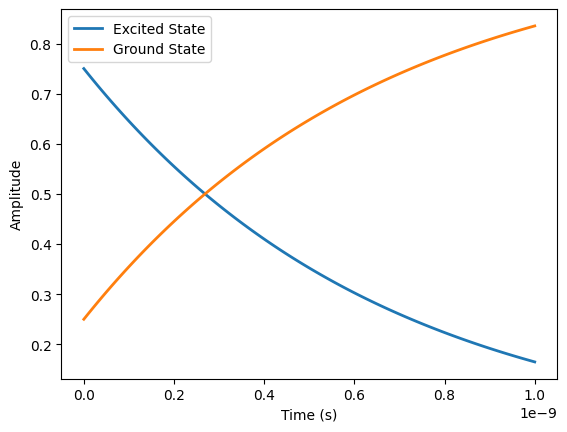

In [10]:

excited = [res.u[i][1, 1].real for i in range(100)]
ground = [res.u[i][0, 0].real for i in range(100)]
times = np.linspace(0, 1000e-12, 100)

plt.plot(times, excited, label="Excited State", linewidth=2)
plt.plot(times, ground, label="Ground State", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
